
# Simulazione di caching basato su similarità di prompt (CLIP)

In [1]:
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt

In [2]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=5000 # Limita per testare velocemente
)
print(f"Colonne disponibili: {list(manager.df.columns)}")

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']


## Valutazione della similarità intra-sessione, extra-sessione e same-user

In [3]:
def compute_intra_session_sims(
    manager,
    num_sessions: Optional[int] = None,
    max_prompts: Optional[int] = None,
    session_gap: int = 30,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_sessions=None: tutte le sessioni, altrimenti ne estrae casuali/ordine.
    • Se max_prompts=None: tutti i prompt di ciascuna sessione, altrimenti limita.
    Ritorna array concatenato di dot‑product tra embeddings consecutive per sessione.
    """
    batches = manager.sample_sessions(
        num_sessions=num_sessions,
        max_prompts=max_prompts,
        random_order=random_order,
        gap=session_gap
    )
    sims_list = []
    for _, embs in batches:
        if embs.shape[0] < 2:
            continue
        M = embs if max_prompts is None else embs[:max_prompts]
        # dot tra righe consecutive
        dots = np.einsum('ij,ij->i', M[1:], M[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_user_sims(
    manager,
    num_users: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: per ogni utente prende tutti i suoi prompt in ordine.
    • Altrimenti estrae num_prompts per utente (random o sequenziale).
    Ritorna array concatenato dei dot‑product tra embeddings consecutive per utente.
    """
    user_dict = manager.sample_user_prompts(
        num_users=num_users,
        random_order=random_order,
        per_user=True
    )
    sims_list = []
    for items in user_dict.values():
        if len(items) < 2:
            continue
        embs = np.stack([emb for _, emb in items], axis=0)
        dots = np.einsum('ij,ij->i', embs[1:], embs[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_random_sims(
    manager,
    num_prompts: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: prende tutti i prompt in ordine (o shuffled se random_order=True).
    • Altrimenti estrae num_prompts a caso o sequenziali.
    Ritorna array di dot‑product tra embeddings consecutive nell’array risultante.
    """
    items = manager.sample_prompts(
        num_prompts=num_prompts,
        random_order=random_order
    )
    if len(items) < 2:
        return np.array([])
    embs = np.stack([emb for _, emb in items], axis=0)
    return np.einsum('ij,ij->i', embs[1:], embs[:-1])


In [4]:
intra = compute_intra_session_sims(manager, num_sessions=None, max_prompts=None, session_gap=30, random_order=True)
print(f"Loaded {len(intra)} intra-session similarities.")
print(f"Mean intra-session similarity: {np.mean(intra) if len(intra) > 0 else 0.0}")
user = compute_user_sims(manager, num_users=None, random_order=True)
print(f"Loaded {len(user)} user similarities.")
print(f"Mean user similarity: {np.mean(user) if len(user) > 0 else 0.0}")
rand = compute_random_sims(manager, num_prompts=None, random_order=True)
print(f"Loaded {len(rand)} random similarities.")
print(f"Mean random similarity: {np.mean(rand) if len(rand) > 0 else 0.0}")

Loaded 3816 intra-session similarities.
Mean intra-session similarity: 0.7688296437263489
Loaded 4426 user similarities.
Mean user similarity: 0.5885436534881592
Loaded 4999 random similarities.
Mean random similarity: 0.3269234895706177


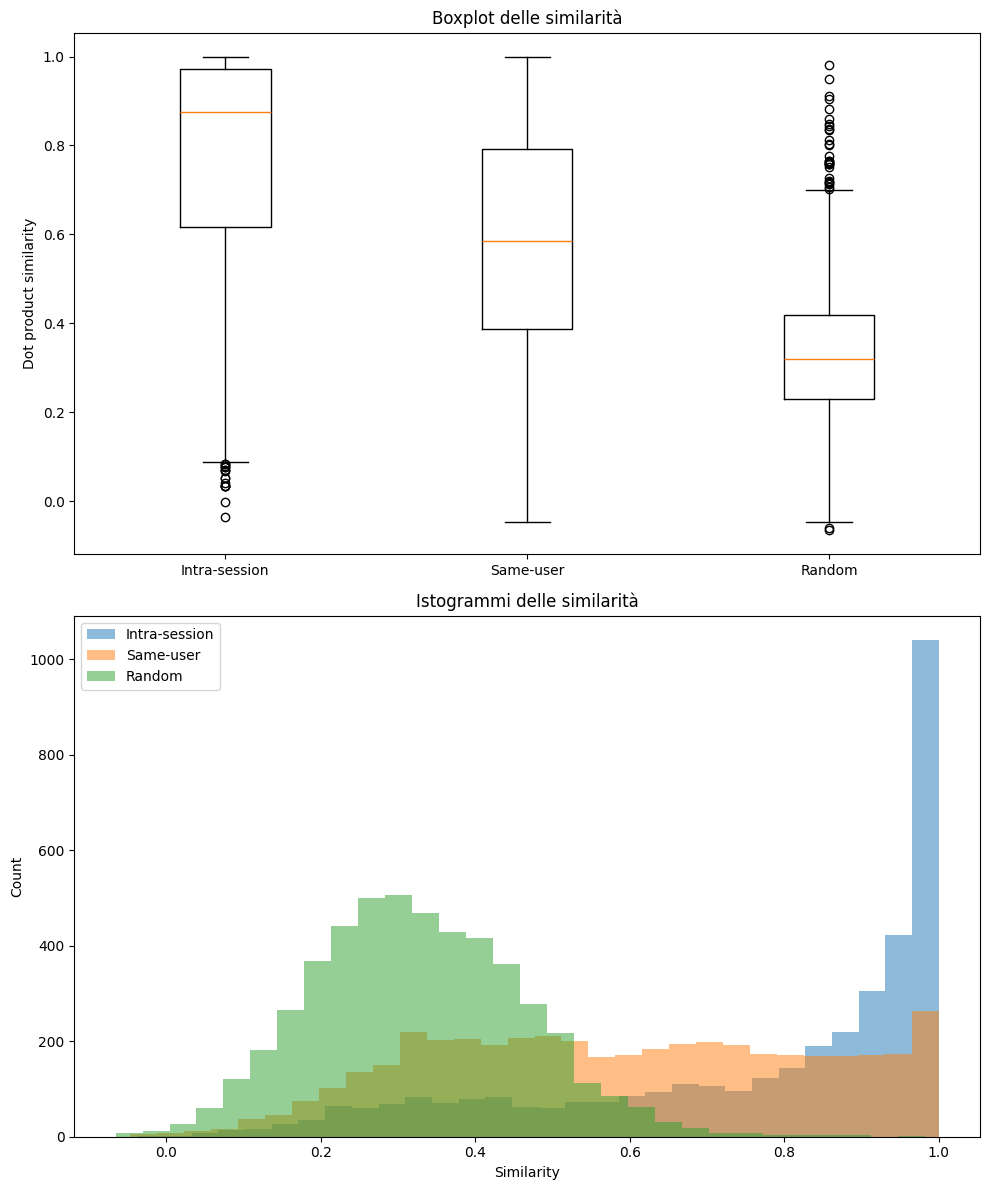

In [5]:

# Histo + boxplot
def plot_distributions(intra, user, rand):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Boxplot comparativo\    
    axs[0].boxplot([intra, user, rand], tick_labels=['Intra-session', 'Same-user', 'Random'])
    axs[0].set_title('Boxplot delle similarità')
    axs[0].set_ylabel('Dot product similarity')

    # Istogrammi affiancati
    N, bins = 1, 30
    axs[1].hist(intra, bins=bins, alpha=0.5, label='Intra-session')
    axs[1].hist(user, bins=bins, alpha=0.5, label='Same-user')
    axs[1].hist(rand, bins=bins, alpha=0.5, label='Random')
    axs[1].set_title('Istogrammi delle similarità')
    axs[1].set_xlabel('Similarity')
    axs[1].set_ylabel('Count')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_distributions(intra, user, rand)


Loaded 6 session gaps.
Means by gap: [np.float32(0.78847665), np.float32(0.77866143), np.float32(0.7720439), np.float32(0.76882964), np.float32(0.7646935), np.float32(0.7613636)]


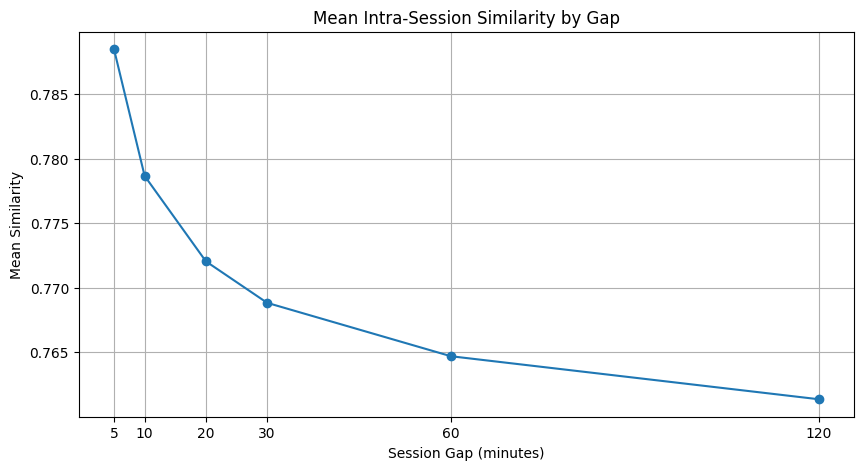

In [6]:
session_gaps = [5, 10, 20, 30, 60, 120]

sims_by_gap = [np.mean(compute_intra_session_sims(manager, num_sessions=None, session_gap=gap, max_prompts=None)) for gap in session_gaps]
print (f"Loaded {len(sims_by_gap)} session gaps.")
print (f"Means by gap: {sims_by_gap}")
# plot sims_by_gap
plt.figure(figsize=(10, 5))
plt.plot(session_gaps, sims_by_gap, marker='o')
plt.title('Mean Intra-Session Similarity by Gap')
plt.xlabel('Session Gap (minutes)')
plt.ylabel('Mean Similarity')
plt.xticks(session_gaps)
plt.grid()
plt.show()